In [3]:
import seaborn as sns # for correlation heatmap
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import pushranker
import datetime
import snrf
import importlib
import random
import pickle
import collections
from matplotlib import pyplot as plt
from pathlib import Path
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from typing import List, Dict, Tuple
from multiprocessing import Pool


In [5]:
push_type = 'scheduled' # local, targeted, scheduled
train_days = 1
train_day = '0516'
test_day = '0517'

LOCAL_DATA_ROOT = Path('./data/')
TRAIN_DATA_ROOT = str(LOCAL_DATA_ROOT / 'train' / 'edition=en_US' / f'push_type={push_type}' / train_day ) # / 'dt=2021-04-30-00')
TEST_DATA_ROOT = str(LOCAL_DATA_ROOT / 'test' / 'edition=en_US' / f'push_type={push_type}' / test_day) # / 'dt=2021-05-01-00')

training_format = snrf.package.get_obj_from_name(pushranker, 'survival_feature_spec.binarized_format_devicetoken')

# input_module = pushranker.local_push
input_module = importlib.import_module(f'pushranker.{push_type}_push')

print(TRAIN_DATA_ROOT)
print(TEST_DATA_ROOT)

data/train/edition=en_US/push_type=scheduled/0516
data/test/edition=en_US/push_type=scheduled/0517


In [6]:
def prepare(root, shuffle=None):
    ds = snrf.tfrecord.read_dataset_from_files(root)
#     ds = ds.shuffle(10000)
    ds = snrf.tfrecord.prepare_dataset_for_use(ds,
                                               input_module.input_spec,
                                               shuffle=shuffle,
                                               training_format=training_format)
    return ds

train_ds = prepare(TRAIN_DATA_ROOT, 10000)
test_ds = prepare(TEST_DATA_ROOT)
type(test_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

## GBDT push ranker

In [13]:
# Transform push-ranker data for GBDT
numeric_features = ['predicted_ctr']
dense_features = ['cgScores', 'a_stats', 'af_dense', 'uf_dense', 'u_hhs']
dense_features_len = [10, 36, 9, 10, 24]
# sparse_features = [
#     'push_id', 'u_cate','u_catev2', 'u_hist_ids', 'u_pub', 'u_pub_ctr', 'u_kw',
#     'a_catev2', 'a_features', 'a_site_id', 'a_kw', 'a_tw'
# ]

def build_numeric_feature(batch) -> List[float]:
    samples = list()
    i = 0
    while True:
        value = list()
        try:
            for f in numeric_features:
                value.append(batch[0][f][i])
        except IndexError:
            break
        else:
            samples.append(value)
            i += 1
    return samples
    

def build_dense_feature(batch) -> List[List[float]]:
    samples = list()
    i = 0
    while True:
        feat_vec = list()
        try:
            for f in dense_features:
                feat_vec.extend(list(batch[0][f][i]))
        except IndexError:
            break
        else:
            samples.append(feat_vec)
            i += 1
    return samples
    

def build_sparse_feature_dict(batch) -> List[Dict]:
    samples = list()
    i = 0
    while True:
        featureDict = dict()
        try:
            for f in sparse_features:
                if f == 'push_id':
                    featureDict[f] = str(batch[0][f][i])  
                else:
                    featureDict[f] = [str(val) for idx, val in np.ndenumerate(batch[0][f][i]) if val]       
        except IndexError:
            break
        else:
            samples.append(featureDict)
            i += 1
    return samples

In [14]:
# # prepare training data
# numeric_feat = list()
# dense_feat = list()
# sparse_samples = list()

# for batch in train_ds.as_numpy_iterator():
#     numeric_feat.extend(build_numeric_feature(batch))
#     dense_feat.extend(build_dense_feature(batch))
# #     sparse_samples.extend(build_sparse_feature_dict(batch))
    
# numeric_feature = np.array(numeric_feat)
# numeric_feat.clear()
# dense_feature = np.array(dense_feat)
# dense_feat.clear()
dense_feature_column = [f'{df}_{i}' for df, l in zip(dense_features, dense_features_len) for i in range(l)]

# build sparse features transformer
# vec = DictVectorizer()
# sparse_feature = vec.fit_transform(sparse_samples).toarray()
# sparse_samples.clear()
# sparse_feature_column = vec.feature_names_
# sparse_feature.shape

In [15]:
# # merge training data
feature_columns = numeric_features + dense_feature_column# + sparse_feature_column
# train_X = np.hstack((numeric_feature, dense_feature))#, sparse_feature))
# train_X.shape

In [16]:
# # prepare testing data
# numeric_feat = list()
# dense_feat = list()
# sparse_samples = list()
# for batch in test_ds.as_numpy_iterator():
#     numeric_feat.extend(build_numeric_feature(batch))
#     dense_feat.extend(build_dense_feature(batch))
# #     sparse_samples.extend(build_sparse_feature_dict(batch))
# numeric_feature = np.array(numeric_feat)
# numeric_feat.clear()
# dense_feature = np.array(dense_feat)
# dense_feat.clear()
# # sparse_feature = vec.transform(sparse_samples).toarray()
# # sparse_samples.clear()
# test_X = np.hstack((numeric_feature, dense_feature))#, sparse_feature))
# numeric_feature.clear()
# dense_feature.clear()
# # sparse_feature.clear()
# test_X.shape

In [17]:
# # prepare labels
# train_y = list()
# test_y = list()

# for train in train_ds:
#     train_y.extend(list(np.array(train[1])))
    
# train_y = np.array(train_y)
# print(len(train_y))

# for test in test_ds:
#     test_y.extend(list(np.array(test[1])))
# test_y = np.array(test_y)
# print(len(test_y))


## XGBOOST API

In [18]:
# gbdt_model = None
# params = {'objective': 'binary:logistic'}
# for d in range(train_days):
#     day = day[:2] + str(int(day[2:]) - d)
#     train_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainX-{day}.npy'))
#     train_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainy-{day}.npy'))
#     xgb_train = xgb.DMatrix(train_X, label=train_y, feature_names=feature_columns)
#     print(f'Data of training day: {day}')
#     print(train_X.shape)
#     gbdt_model = xgb.train(params, xgb_train, xgb_model=gbdt_model)


In [19]:
# test_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testX-0501.npy'))
# test_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testy-0501.npy'))
# print(test_X.shape)
# test = xgb.DMatrix(test_X, label=test_y, feature_names=feature_columns)
# gbdt_pred_ctr = gbdt_model.predict(test)

In [20]:
# len(gbdt_pred_ctr)

In [21]:
# MODEL_ROOT_PATH = Path('./model')
# file_name = f"xgbmodel-{push_type}-{train_days}.xgbmodel"
# model_path = str(MODEL_ROOT_PATH / f'{push_type}-push' / 'GBDT' / file_name)
# gbdt_model.save_model(model_path)

In [22]:
# # feature_important = gbdt_model.get_booster().get_score(importance_type='weight')
# feature_important = gbdt_model.get_fscore()
# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score")
# data.plot(kind='barh',figsize=(8,24))

## XGBOOST Sklearn API
Before starting the training job, run `prepare-gbdt-training-data` first to generate the training and testing data.

In [ ]:
%%time

gbdt_model = xgb.XGBClassifier()
# gbdt_model = xgb.XGBRegressor()

# model = xgb.XGBRegressor(n_jobs=1)
# clf = GridSearchCV(model,
#                    {'max_depth': [2, 4, 6],
#                     'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=1)
# clf.fit(train_X, train_y)
# print(clf.best_score_)
# print(clf.best_params_)
tmp_model = None
for d in range(train_days):
    td = train_day[:2] + str(int(train_day[2:]) - d)
    print(td)
    train_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainX-{td}.npy'))
    train_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainy-{td}.npy'))
    tmp_model = gbdt_model.fit(train_X, train_y, xgb_model=tmp_model)


0516


/home/ec2-user/anaconda3/envs/pranker/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:19:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# model path
MODEL_ROOT_PATH = Path('./model')
file_name = f"xgbmodel-{push_type}-{train_day}-{train_days}.pkl"
model_path = str(MODEL_ROOT_PATH / f'{push_type}-push' / 'GBDT' / file_name)

# save
pickle.dump(gbdt_model, open(model_path, "wb"))

# load
# gbdt_model = pickle.load(open(model_path, "rb"))

In [ ]:
train_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainX-{train_day}.npy'))
train_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainy-{train_day}.npy'))

In [ ]:
test_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testX-{test_day}.npy'))
test_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testy-{test_day}.npy'))
print(test_X.shape)

In [ ]:
print(sum(train_y))
print(sum(test_y))

In [ ]:
# plot_confusion_matrix(gbdt_model, test_X, test_y)
# plt.show()

In [ ]:
%%time
gbdt_pred = gbdt_model.predict_proba(test_X)
# gbdt_pred = gbdt_model.predict(test_X) # for regressor
len(gbdt_pred)

In [ ]:
gbdt_pred_ctr = gbdt_pred[:, 1]
# gbdt_pred_ctr = gbdt_pred # for regressor

In [ ]:
plt.figure(figsize=(16, 16), dpi=300)
plt.barh(feature_columns, gbdt_model.feature_importances_)

## DNN push ranker & For You GBDT ranker

In [7]:
## DNN push-ranker
# dnn_model_name = f'{train_days}-day'
dnn_model_name = f'original--{train_day}'

hps = getattr(pushranker.hyperparam, push_type)
dnn_model_1 = pushranker.model.make_model_assembly(hps, input_module.input_spec)
dnn_model_1.hazard_model.load_weights(f'./model/{push_type}-push/DNN/{dnn_model_name}/pushranker')
pushranker.model.initialize_for_training(dnn_model_1, hps)

NumericFeature(key='predicted_ctr', shape=[], dtype=tf.float32)
CategoricalFeature(key='push_id', shape=[], vocab_size=100, has_weight=False, do_own_hash=True, embedding_key=None, score_key='', key_dtype=tf.string)
CategoricalFeature(key='u_cate', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_catev2', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=True, embedding_key='catev2', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub_ctr', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_kw', shape=[None], vocab_size=200000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_s', key_dt

Assembly(training_adapter=<pushranker.model.TrainingAdapter object at 0x7efff46eb7d0>, hazard_model=<tensorflow.python.keras.engine.functional.Functional object at 0x7f0033635850>)

In [9]:
%%time
dnn_pred_1 = dnn_model_1.training_adapter.predict(test_ds)
dnn_pred_ctr = np.array([s[0] for s in dnn_pred_1])

/home/ec2-user/anaconda3/envs/pranker/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['device_token', 'period_end_timestamp', 'period_start_timestamp', 'received_timestamp', 'sent_timestamp', 'specific_click'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


CPU times: user 4h 27min 5s, sys: 4h 17min 39s, total: 8h 44min 44s
Wall time: 30min 38s


In [8]:
## DNN push-ranker
# dnn_model_name = f'{train_days}-day'
dnn_model_name = f'lessIds--{train_day}'

hps = getattr(pushranker.hyperparam, push_type)
dnn_model_2 = pushranker.model.make_model_assembly(hps, input_module.less_ids_input_spec)
dnn_model_2.hazard_model.load_weights(f'./model/{push_type}-push/DNN/{dnn_model_name}/pushranker')
pushranker.model.initialize_for_training(dnn_model_2, hps)

NumericFeature(key='predicted_ctr', shape=[], dtype=tf.float32)
CategoricalFeature(key='u_cate', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_catev2', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=True, embedding_key='catev2', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub_ctr', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_kw', shape=[None], vocab_size=200000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_s', key_dtype=tf.int64)
NumericFeature(key='cgScores', shape=[10], dtype=tf.float32)
NumericFeature(key='u_hhs', shape=[24], dtype=tf.float32)
NumericFeature(key

Assembly(training_adapter=<pushranker.model.TrainingAdapter object at 0x7efff4458c50>, hazard_model=<tensorflow.python.keras.engine.functional.Functional object at 0x7efff4354490>)

In [10]:
%%time
dnn_pred_2 = dnn_model_2.training_adapter.predict(test_ds)
dnn_pred_ctr = np.array([s[0] for s in dnn_pred_2])

/home/ec2-user/anaconda3/envs/pranker/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['device_token', 'period_end_timestamp', 'period_start_timestamp', 'push_id', 'received_timestamp', 'sent_timestamp', 'specific_click', 'u_hist_ids'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


CPU times: user 4h 15min 21s, sys: 4h 18min 5s, total: 8h 33min 26s
Wall time: 30min 33s


In [ ]:
devtok = list()
label = list()
fy_gbdt_ctr = list()

for feature_batch, label_batch, devtok_batch in test_ds.as_numpy_iterator():
    for f, l, dtk in zip(feature_batch['predicted_ctr'], label_batch, devtok_batch):
        fy_gbdt_ctr.append(f)
        label.append(l)
        devtok.append(dtk[0])
devtok = np.array(devtok)
label = np.array(label)
fy_gbdt_ctr = np.array(fy_gbdt_ctr)

## Predicted CTR Distribution

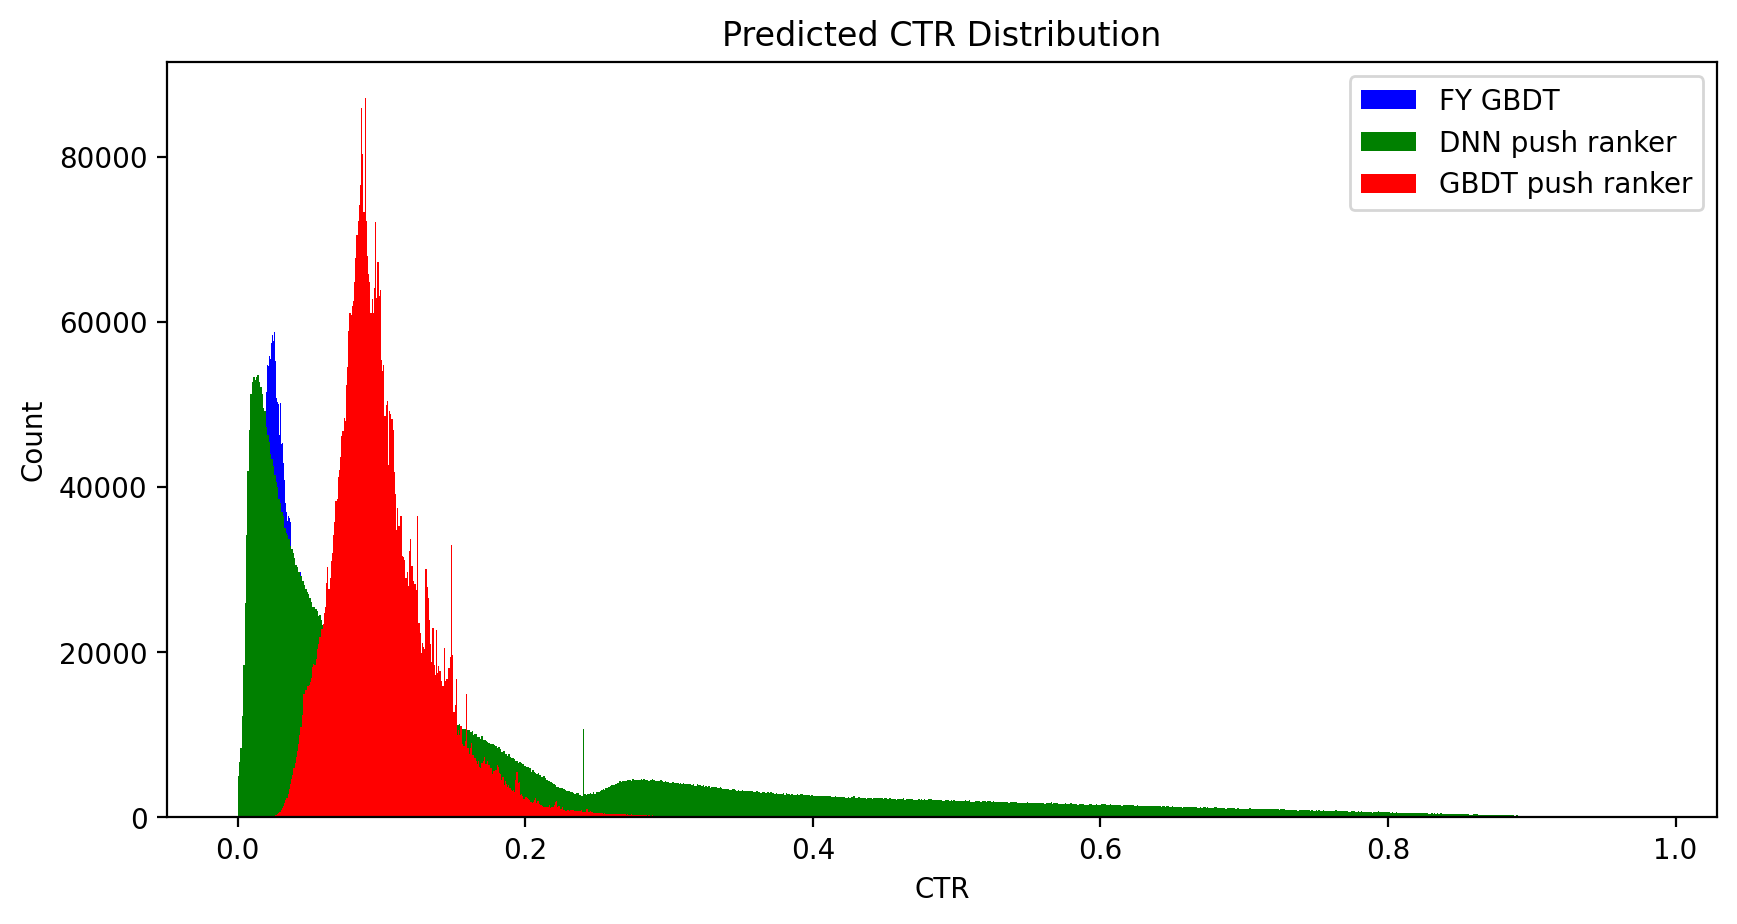

In [69]:
plt.figure(figsize=(10, 5), dpi=200)
_ = plt.hist(fy_gbdt_ctr, bins=1000, color='b', label='FY GBDT')
_ = plt.hist(dnn_pred_ctr, bins=1000, color='g', label='DNN push ranker')
_ = plt.hist(gbdt_pred_ctr, bins=1000, color='r', label='GBDT push ranker')

plt.xlabel('CTR')
plt.ylabel('Count')
plt.title("Predicted CTR Distribution")
plt.legend(loc="upper right")
plt.show()

## ROC AUC

In [70]:
fpr_gbdt, tpr_gbdt, thresholds_gbdt = roc_curve(test_y, gbdt_pred_ctr)
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(label, dnn_pred_ctr)
fpr_fy_gbdt, tpr_fy_gbdt, thresholds_fy_gbdt = roc_curve(label, fy_gbdt_ctr)
gbdt_auc = auc(fpr_gbdt, tpr_gbdt)
dnn_auc = auc(fpr_dnn, tpr_dnn)
fy_gbdt_auc = auc(fpr_fy_gbdt, tpr_fy_gbdt)
print('GBDT push ranker AUC: ', gbdt_auc)
print('DNN push ranker AUC: ', dnn_auc)
print('FY GBDT AUC: ', fy_gbdt_auc)

GBDT push ranker AUC:  0.5165218424072445
DNN push ranker AUC:  0.8327192222892272
FY GBDT AUC:  0.6135776423153847


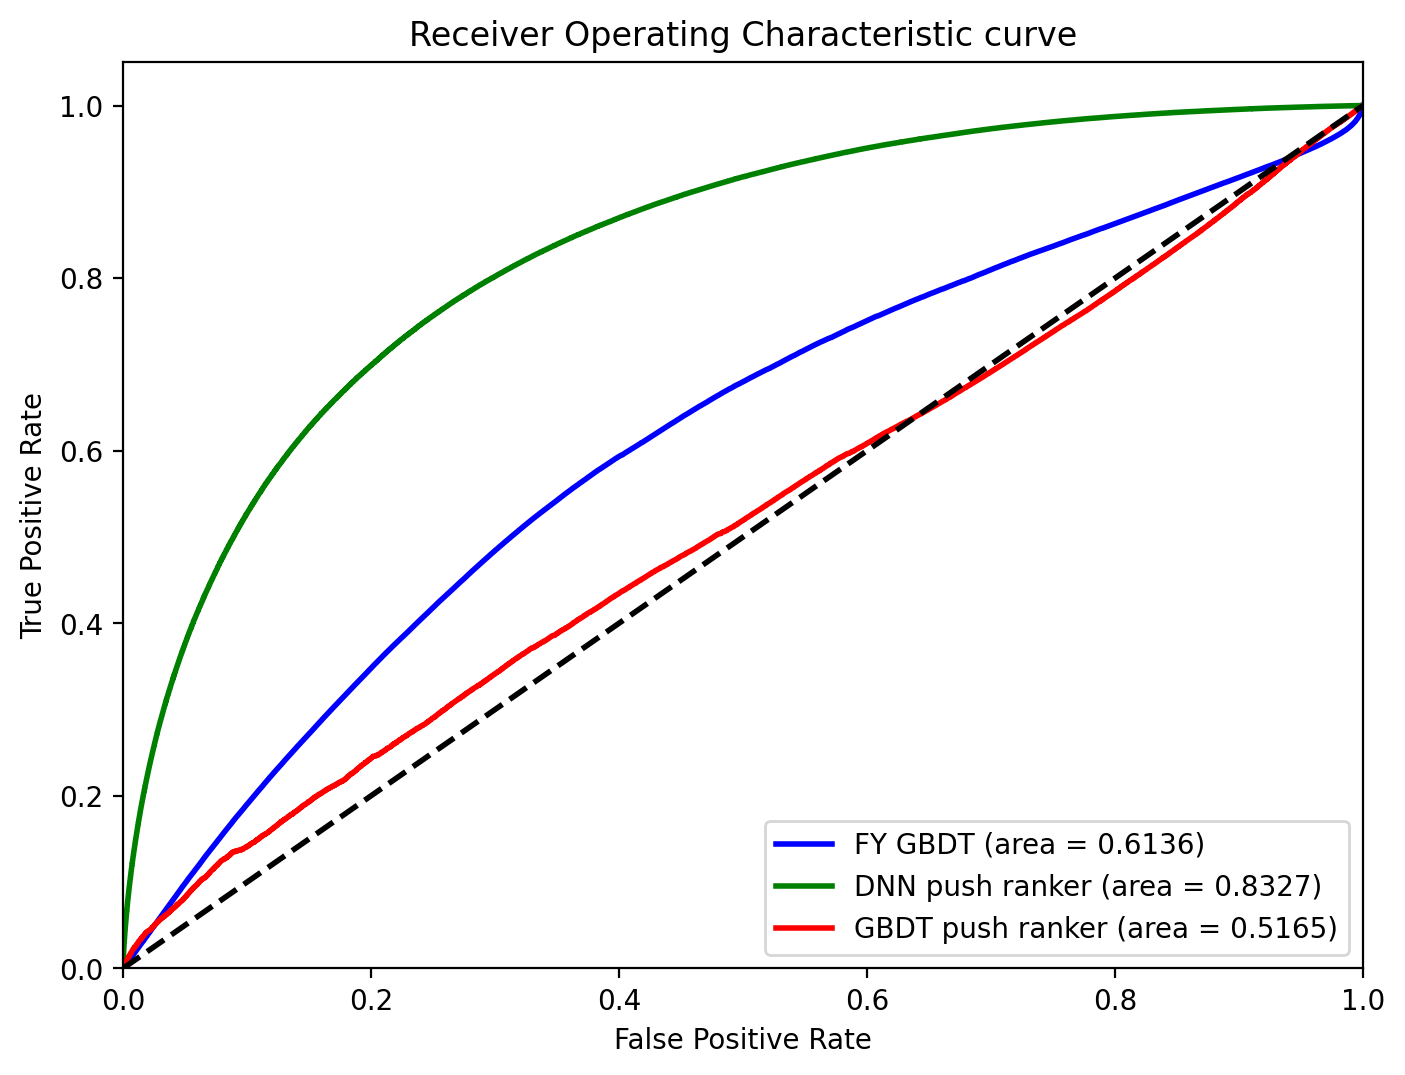

In [71]:
# Plot ROC
plt.figure(figsize=(8, 6), dpi=200)
lw = 2
plt.plot(fpr_fy_gbdt, tpr_fy_gbdt, color='b',
         lw=lw, label='FY GBDT (area = %0.4f)' % fy_gbdt_auc)
plt.plot(fpr_dnn, tpr_dnn, color='g',
         lw=lw, label='DNN push ranker (area = %0.4f)' % dnn_auc)
plt.plot(fpr_gbdt, tpr_gbdt, color='r',
         lw=lw, label='GBDT push ranker (area = %0.4f)' % gbdt_auc)
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

## Average Precision

In [72]:
pre_gbdt, rec_gbdt, thresholds_gbdt = precision_recall_curve(test_y, gbdt_pred_ctr)
pre_dnn, rec_dnn, thresholds_dnn = precision_recall_curve(label, dnn_pred_ctr)
pre_fy_gbdt, rec_fy_gbdt, thresholds_fy_gbdt = precision_recall_curve(label, fy_gbdt_ctr)
gbdt_ap = average_precision_score(test_y, gbdt_pred_ctr)
dnn_ap = average_precision_score(label, dnn_pred_ctr)
fy_gbdt_ap = average_precision_score(label, fy_gbdt_ctr)
print('GBDT AP: {0:0.4f}'.format(gbdt_ap))
print('DNN AP: {0:0.4f}'.format(dnn_ap))
print('FY GBDT AP: {0:0.4f}'.format(fy_gbdt_ap))

GBDT AP: 0.1448
DNN AP: 0.4588
FY GBDT AP: 0.1794


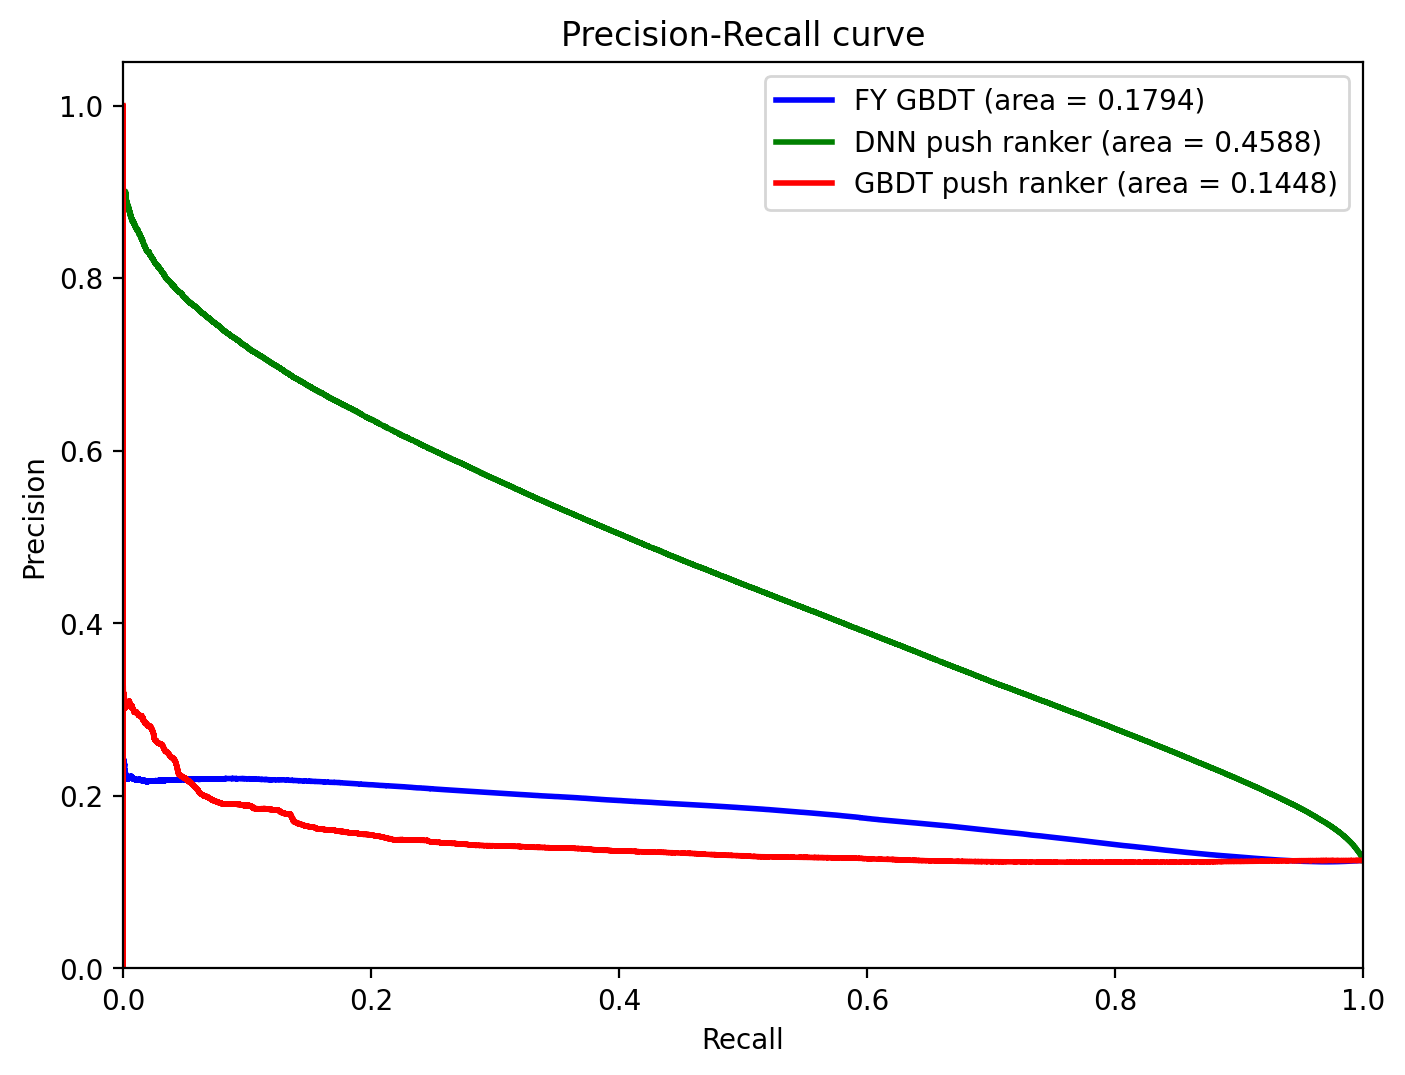

In [73]:
# Plot PR
plt.figure(figsize=(8, 6), dpi=200)
lw = 2
plt.plot(rec_fy_gbdt, pre_fy_gbdt, color='blue',
         lw=lw, label='FY GBDT (area = %0.4f)' % fy_gbdt_ap)
plt.plot(rec_dnn, pre_dnn, color='green',
         lw=lw, label='DNN push ranker (area = %0.4f)' % dnn_ap)
plt.plot(rec_gbdt, pre_gbdt, color='red',
         lw=lw, label='GBDT push ranker (area = %0.4f)' % gbdt_ap)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

## Overall top-k Precision

In [28]:
gbdt_score_label = list()
dnn_score_label = list()
fygbdt_score_label = list()
length = len(label)
for i in range(length):
    gbdt_score_label.append((gbdt_pred_ctr[i], label[i]))
    dnn_score_label.append((dnn_pred_ctr[i], label[i]))
    fygbdt_score_label.append((fy_gbdt_ctr[i], label[i]))

gbdt_score_label.sort(reverse=True)
dnn_score_label.sort(reverse=True)
fygbdt_score_label.sort(reverse=True)

In [29]:
topk = [1, 2, 5, 10, 20, 50, 100, 1000, 10000, 100000]

for i in topk:
    print(f'top-{i} precision:')
    print('gbdt: {0:0.4f}'.format(sum((l for _, l in gbdt_score_label[:i]))/i))
    print('dnn: {0:0.4f}'.format(sum((l for _, l in dnn_score_label[:i]))/i))
    print('fy gbdt: {0:0.4f}'.format(sum((l for _, l in fygbdt_score_label[:i]))/i))

top-1 precision:
gbdt: 0.0000
dnn: 0.0000
fy gbdt: 0.0000
top-2 precision:
gbdt: 0.0000
dnn: 0.0000
fy gbdt: 0.0000
top-5 precision:
gbdt: 0.0000
dnn: 0.0000
fy gbdt: 0.0000
top-10 precision:
gbdt: 0.2000
dnn: 0.2000
fy gbdt: 0.2000
top-20 precision:
gbdt: 0.3500
dnn: 0.2000
fy gbdt: 0.4500
top-50 precision:
gbdt: 0.4200
dnn: 0.6200
fy gbdt: 0.4200
top-100 precision:
gbdt: 0.4300
dnn: 0.7600
fy gbdt: 0.4600
top-1000 precision:
gbdt: 0.3880
dnn: 0.8890
fy gbdt: 0.3880
top-10000 precision:
gbdt: 0.3581
dnn: 0.8594
fy gbdt: 0.3595
top-100000 precision:
gbdt: 0.3115
dnn: 0.7728
fy gbdt: 0.3643


In [30]:
topk = [10000]

for i in topk:
    print(f'top-{i} precision:')
    print('gbdt: {0:0.4f}'.format(sum((l for _, l in gbdt_score_label[:i]))/i))
    print('dnn: {0:0.4f}'.format(sum((l for _, l in dnn_score_label[:i]))/i))
    print('fy gbdt: {0:0.4f}'.format(sum((l for _, l in fygbdt_score_label[:i]))/i))

top-10000 precision:
gbdt: 0.3581
dnn: 0.8594
fy gbdt: 0.3595


## Mean per-user top-k precision
Average top-k precision among users (device token)

In [31]:
len_samples = len(devtok)
user_fy_gbdt = collections.defaultdict(list)
user_push_gbdt = collections.defaultdict(list)
user_dnn = collections.defaultdict(list)
for i in range(len_samples):
    user_fy_gbdt[devtok[i]].append((fy_gbdt_ctr[i], label[i]))
    user_push_gbdt[devtok[i]].append((gbdt_pred_ctr[i], label[i]))
    user_dnn[devtok[i]].append((dnn_pred_ctr[i], label[i]))
assert len(user_fy_gbdt) == len(user_push_gbdt) == len(user_dnn)

In [32]:
topk = [1, 2, 3]

def getMeanTopkPrecision(d):
    for k in topk:
        p = 0
        for _, scores_labels in d.items():
            scores_labels.sort(reverse=True)
            p += sum(l for _, l in scores_labels[:k])/k
        p /= len(d)
        yield p
       
print(f'fy-gbdt:', list(getMeanTopkPrecision(user_fy_gbdt)))
print(f'push-gbdt:', list(getMeanTopkPrecision(user_push_gbdt)))
print(f'dnn:', list(getMeanTopkPrecision(user_dnn)))

fy-gbdt: [0.045630801883806776, 0.04416017205830266, 0.03971578148307234]
push-gbdt: [0.04161538989871239, 0.04240151022370542, 0.03905752200670073]
dnn: [0.040309263217150886, 0.04154640362324403, 0.03860825267539711]


In [33]:
# positive sample rate
sum(label)/len(label)

0.0698443305909392

In [34]:
# average number of samples per user
sum(len(article) for article in user_fy_gbdt.values())/len(user_fy_gbdt)

2.2708203205488195

In [35]:
# how many users have more than 1 article
print(f'#total users: {len(user_fy_gbdt)}')
print(f'#users have 1 article: {sum(1 for article in user_fy_gbdt.values() if len(article) == 1)}')
print(f'#users have 1 article and it is pos: {sum(1 for article in user_fy_gbdt.values() if (len(article) == 1) and sum(l for _, l in article)>0)}')
print(f'#users have 2 article: {sum(1 for article in user_fy_gbdt.values() if len(article) == 2)}')
print(f'#users have more than 2 article: {sum(1 for article in user_fy_gbdt.values() if len(article) > 2)}')

#total users: 14850780
#users have 1 article: 4496792
#users have 1 article and it is pos: 46695
#users have 2 article: 4926742
#users have more than 2 article: 5427246


In [3]:
# filter out users 

In [7]:
%%time

def moreThanOneNewsAndAtLeastOnePositive(newsList: List) -> int:
    return 1 if len(newsList) > 1 and sum(l for _, l in newsList) > 0 else 0

# #users have more than one news and at least one positive example
num_processors = 32
p = Pool(processes=num_processors)
r = p.map(moreThanOneNewsAndAtLeastOnePositive, user_fy_gbdt.values())
sum(r)

NameError: name 'user_fy_gbdt' is not defined